# Extracting Feature Map - SST

In [1]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16

In [2]:
s1_model = tf.keras.models.load_model('/Users/sankeerthana/Documents/NTU/YEAR_3/NTU_URECA/Codes/NSCC/cropped_imgs/SST/s1/s1_sst_resnet50.h5')

Metal device set to: Apple M1


2022-06-25 15:21:32.603778: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-25 15:21:32.603895: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
s1_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

To generate feature maps, we have to build a visualization model that takes an image as an input and has the above-mentioned layer_outputs as output functions.

In [6]:
#img_path = "/Users/sankeerthana/Documents/NTU/YEAR_3/NTU_URECA/Datasets/try2_test/subject_dependent_sst/s1/test/3_happy/_cz_eeg5_3_img_147.jpg"
img_path = "/Users/sankeerthana/Desktop/img.png"
img = image.load_img(img_path, target_size=(256,256))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print('Shape of Image Tensor:', img_tensor.shape)

Shape of Image Tensor: (1, 256, 256, 3)


Where it is in the format of (# imgs, width, height, # channels) where # channels refers to RGB[3] or Greyscale[1].

## Extracting the Feature Map for the First Block

In [27]:
#Extracting only convolutional layers as the BN layer and dropout layers have no new features learnt in them
layer_outputs = [layer.output for layer in s1_model.layers if 'conv3' in layer.name]

#Creating an instance of the Model class where layers are grouped with inference and training features.
activation_model = Model(inputs=s1_model.input, outputs=layer_outputs)

layer_names = []

for layer in activation_model.layers:
    layer_names.append(layer.name)
    
#Is a list that contains numpy arrays of the output of all the layers
intermediate_activations = activation_model.predict(img_tensor)

first_layer_activation = intermediate_activations[0]
second_layer_activation = intermediate_activations[1]
third_layer_activation = intermediate_activations[2]
fourth_layer_activation = intermediate_activations[3]

activation_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

2022-06-25 15:39:11.153589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


There are 5 layers where the first layer is the input layer, the output is the same test image that was sent in. Next is teh padding layer where the padding os 6x6 are added on all sides, hence, the size of the images increases, howeve,r the number of channels remains the same as there is no convolutoin operation done yet. Next, we have Conv2D layer where a convolution operation with 64 filters was done.

## Test Image

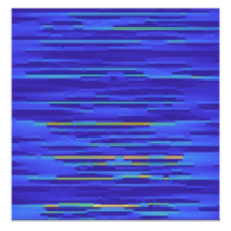

In [28]:
plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

### Conv Padding

Shape: (1, 32, 32, 128)


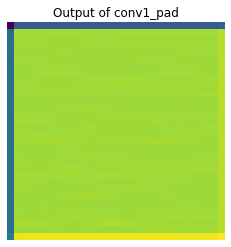

In [29]:
print('Shape:', first_layer_activation.shape)
plt.imshow(first_layer_activation[0, :, :, 2], cmap='viridis')
plt.title('Output of ' + layer_names[1])
plt.axis('off')
plt.show()

Here there are 3 channels as the input sent is a coloured image with RGB channels, hence 3 channels. Padding of 6x6 is added around, thus resulting in an increase in the size to 262x262 from 256x256. This can also be seen by the dark border around the image.

### Conv2D Layer

Shape: (1, 32, 32, 128)


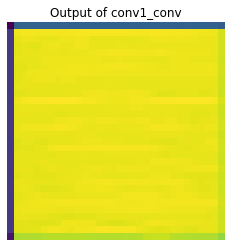

In [30]:
print('Shape:', second_layer_activation.shape)
plt.imshow(second_layer_activation[0, :, :, 63], cmap='viridis')
plt.title('Output of ' + layer_names[2])
plt.axis('off')
plt.show()

Here, the number of channels is 63 as there were 64 filters that were used, in the padding layer, the output of the convolution layer Conv2D, is 128x128. This seems to be an abstract representation of the actual test images where only edges are being detected first.

### Batch Normalization Layer

Shape: (1, 32, 32, 128)


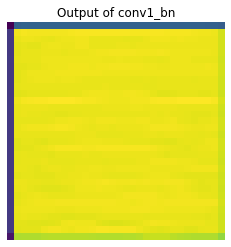

In [31]:
print('Shape:', third_layer_activation.shape)
plt.imshow(third_layer_activation[0, :, :, 63], cmap='viridis')
plt.title('Output of ' + layer_names[3])
plt.axis('off')
plt.show()

This is the output of the Batch Normalisation layer, since there is no convolutional operation done here, there is no change in the feature map as well.

### ReLu Activation Layer

Shape: (1, 32, 32, 128)


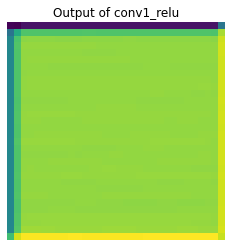

In [32]:
print('Shape:', fourth_layer_activation.shape)
plt.imshow(fourth_layer_activation[0, :, :, 63], cmap='viridis')
plt.title('Output of ' + layer_names[4])
plt.axis('off')
plt.show()

This is the output of the first convolutional block, where most of the features are low level edge fetaures.

In [13]:
s1_layer_names = [layer.name for layer in s1_model.layers]
s1_layer_names

['input_1',
 'conv1_pad',
 'conv1_conv',
 'conv1_bn',
 'conv1_relu',
 'pool1_pad',
 'pool1_pool',
 'conv2_block1_1_conv',
 'conv2_block1_1_bn',
 'conv2_block1_1_relu',
 'conv2_block1_2_conv',
 'conv2_block1_2_bn',
 'conv2_block1_2_relu',
 'conv2_block1_0_conv',
 'conv2_block1_3_conv',
 'conv2_block1_0_bn',
 'conv2_block1_3_bn',
 'conv2_block1_add',
 'conv2_block1_out',
 'conv2_block2_1_conv',
 'conv2_block2_1_bn',
 'conv2_block2_1_relu',
 'conv2_block2_2_conv',
 'conv2_block2_2_bn',
 'conv2_block2_2_relu',
 'conv2_block2_3_conv',
 'conv2_block2_3_bn',
 'conv2_block2_add',
 'conv2_block2_out',
 'conv2_block3_1_conv',
 'conv2_block3_1_bn',
 'conv2_block3_1_relu',
 'conv2_block3_2_conv',
 'conv2_block3_2_bn',
 'conv2_block3_2_relu',
 'conv2_block3_3_conv',
 'conv2_block3_3_bn',
 'conv2_block3_add',
 'conv2_block3_out',
 'conv3_block1_1_conv',
 'conv3_block1_1_bn',
 'conv3_block1_1_relu',
 'conv3_block1_2_conv',
 'conv3_block1_2_bn',
 'conv3_block1_2_relu',
 'conv3_block1_0_conv',
 'conv3_

In [15]:
conv_layer_names = [layer.name for layer in s1_model.layers if '_conv' in layer.name]
conv_layer_outputs = [layer.output for layer in s1_model.layers if '_conv' in layer.name]

if len(conv_layer_names) == len(conv_layer_outputs):
    print('Both are of the same length!')
    print('Length:', len(conv_layer_names))

Both are of the same length!
Length: 53


In [16]:
add_layer_names = [layer.name for layer in s1_model.layers if '_add' in layer.name]
add_layer_outputs = [layer.output for layer in s1_model.layers if '_add' in layer.name]

if len(add_layer_names) == len(add_layer_outputs):
    print('Both are of the same length!')
    print('Length:', len(add_layer_names))

Both are of the same length!
Length: 16


In [17]:
out_layer_names = [layer.name for layer in s1_model.layers if '_out' in layer.name]
out_layer_outputs = [layer.output for layer in s1_model.layers if '_out' in layer.name]

if len(out_layer_names) == len(out_layer_outputs):
    print('Both are of the same length!')
    print('Length:', len(out_layer_names))

Both are of the same length!
Length: 16


2022-06-25 15:40:16.234422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/var/folders/54/f2chvxk17fd0vhl03xl62d_80000gn/T/ipykernel_1699/2950716806.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(scale * display_grid.shape[1],
/var/folders/54/f2chvxk17fd0vhl03xl62d_80000gn/T/ipykernel_1699/2950716806.py:34: RuntimeWarning: divide by zero encountered in true_divide
  channel_image /= channel_image.std()


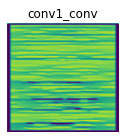

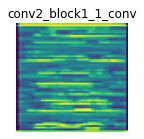

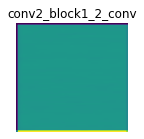

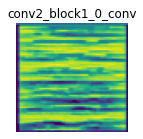

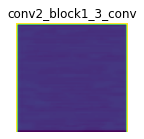

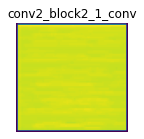

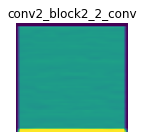

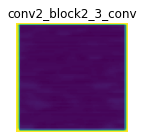

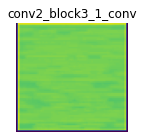

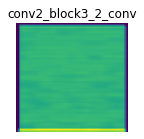

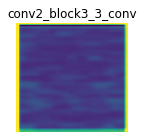

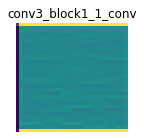

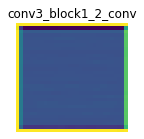

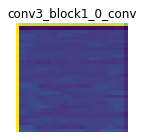

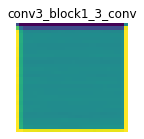

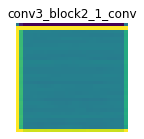

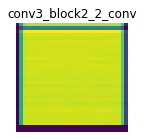

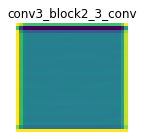

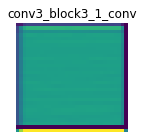

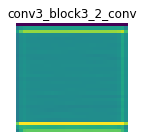

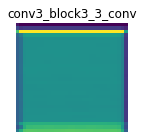

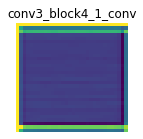

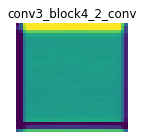

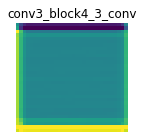

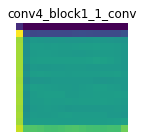

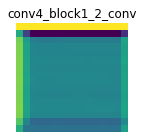

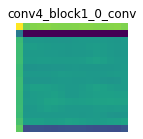

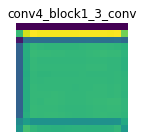

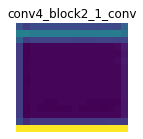

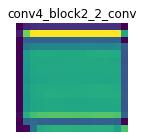

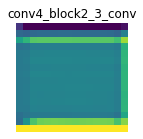

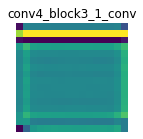

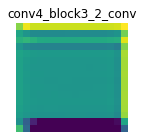

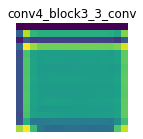

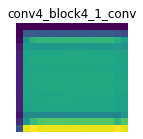

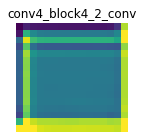

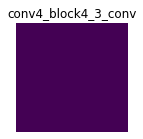

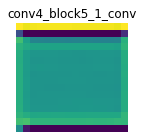

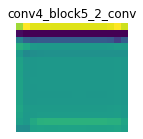

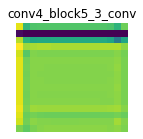

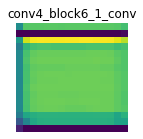

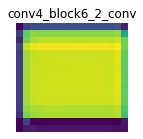

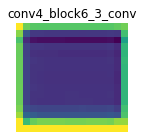

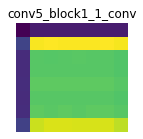

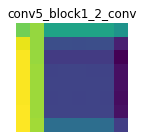

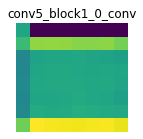

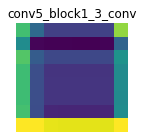

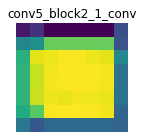

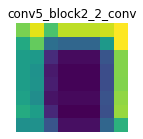

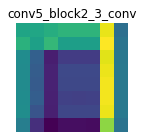

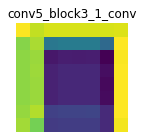

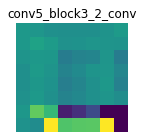

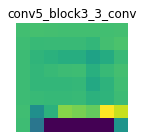

<Figure size 432x288 with 0 Axes>

In [33]:
layer_names = conv_layer_names
#layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

#layer_outputs = [layer.output for layer in vgg.layers if layer.name in layer_names]
layer_outputs = conv_layer_outputs

activation_model = Model(inputs=s1_model.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

images_per_row = 1
max_images = 1

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, intermediate_activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    n_features = min(n_features, max_images)

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 2. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.axis('off')
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()
plt.savefig(fname="/Users/sankeerthana/Desktop/sst_feat_maps.png", format='png')

In [230]:
activation_model.summary()

Model: "model_108"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

savioiur: https://github.com/ardendertat/Applied-Deep-Learning-with-Keras/blob/master/notebooks/Part%204%20(GPU)%20-%20Convolutional%20Neural%20Networks.ipynb

In [ ]:
from vis.utils import utils

#visualising the filters
max_filters = 40
selected_indices = []
vis_images = [[], [], [], [], []]
i = 0
selected_filters = [[0, 3, 11, 25, 26, 33, 42, 62], 
    [8, 21, 23, 38, 39, 45, 50, 79], 
    [40, 48, 52, 54, 81, 107, 224, 226],
    [58, 79, 86, 216, 307, 426, 497, 509],
    [2, 7, 41, 84, 103, 306, 461, 487]]

for layer_name in layer_names:
    layer_idx = utils.find_layer_idx(model, layer_name)

    # Visualize all filters in this layer.
    if selected_filters:
        filters = selected_filters[i]
    else:
        filters = sorted(np.random.permutation(get_num_filters(model.layers[layer_idx]))[:max_filters])
    selected_indices.append(filters)

    # Generate input image for each filter.
    for idx in filters:
        img = visualize_activation(model, layer_idx, filter_indices=idx, tv_weight=0., 
                                   input_modifiers=[Jitter(0.05)], max_iter=300) 
        vis_images[i].append(img)

    # Generate stitched image palette with 4 cols so we get 2 rows.
    stitched = utils.stitch_images(vis_images[i], cols=4)    
    plt.figure(figsize=(20, 30))
    plt.title(layer_name)
    plt.axis('off')
    plt.imshow(stitched)
    plt.show()
    i += 1
